# Experiments with Doc2Vec

Try to represent code in Doc2Vec. 

## Setup

In [1]:
import multiprocessing
from pathlib import Path

import gensim.models.doc2vec
import regex
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from javalang import tokenizer

from code_embeddings.utils import tokenize

assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"


## Build and Train the Model

In [2]:
test_code_dir = Path('test_data')
train_code_dir = Path('training_data')
models_dir = Path('models')

In [3]:
def split_methods(code):
    """Parse Java files into separate methods

        :param code: Java code to parse.
        :rtype: map
    """
    pattern = r'(?:(?:public|private|static|protected)\s+)*\s*[\w\<\>\[\]]+\s+\w+\s*\([^{]+({(?:[^{}]+\/\*.*?\*\/|[^{}]+\/\/.*?$|[^{}]+|(?1))*+})'
    scanner = regex.finditer(pattern, code, regex.MULTILINE)
    return map(lambda match: match.group(0), scanner)

In [4]:
def read_train_corpus():
    count = 0
    for i, file in enumerate(train_code_dir.glob('./java_projects/**/*.java')):
        if not file.is_file():  # oddly, some of these are not files
            continue
        with file.open() as f:
            try:
                code = f.read()
                methods = split_methods(code)
                for method in methods:
                    tokens = list(tokenizer.tokenize(method))
                    tokens = [token for t in tokens for token in t.value.split(" ")]
                    if tokens:
                        tag = "Java_%s" % count
                        count += 1
                        source = "github"
                        path = file.__fspath__()
                        yield TaggedDocument(tokens, [tag, source, path])
            except tokenizer.LexerError as e:
                # print("%s: %s" % (type(e).__name__, e))
                pass
            except UnicodeDecodeError as e:
                # print("%s: %s" % (type(e).__name__, e))
                pass
            except Exception as e:
                print("%s: %s" % (type(e).__name__, e))
                pass
        if i % 10000 == 0:
            print("Processed %s records" % i)
        if i > 100000:
            break
            
    # also include test corpus in training! 
    for programming_language in test_code_dir.glob('./Java'):
        if not programming_language.is_dir():
            continue
        for programming_task in programming_language.glob('./*'):
            if not programming_task.is_dir():
                continue
            for implementation in programming_task.glob('./*'):
                with implementation.open() as f:
                    try:
                        code = f.read()
                        tokens = list(tokenizer.tokenize(code))
                        tokens = [token for t in tokens for token in t.value.split(" ")]
                        if tokens:
                            tag = "Java_%s" % count
                            count += 1
                            source = "rosetta"
                            path = file.__fspath__()
                            yield TaggedDocument(tokens, [tag, source, path])
                    except Exception as e:
                        print("Warning: %s" % e)
                        pass


%time train_corpus = list(read_train_corpus())
print("Training corpus size: %s" % len(train_corpus))


Processed 10000 records


Processed 20000 records


Processed 30000 records


Processed 40000 records


Processed 50000 records


Processed 60000 records


Processed 70000 records


Processed 80000 records


Processed 90000 records


Processed 100000 records


CPU times: user 14min 47s, sys: 31.5 s, total: 15min 19s
Wall time: 16min 20s
Training corpus size: 606570


In [5]:
def read_test_corpus():
    color_val = 0
    for programming_language in test_code_dir.glob('./Java'):
        if not programming_language.is_dir():
            continue
        for programming_task in programming_language.glob('./*'):
            if not programming_task.is_dir():
                continue
            color_val += 1
            for implementation in programming_task.glob('./*'):
                with implementation.open() as f:
                    try:
                        code = f.read()
                        tokens = list(tokenizer.tokenize(code))
                        tokens = [token for t in tokens for token in t.value.split(" ")]
                        if tokens:
                            yield TaggedDocument(tokens, [programming_task.name, implementation.name, programming_language.name, color_val])
                    except Exception as e:
                        print("Warning: %s" % e)
                        pass
                
                
test_corpus = list(read_test_corpus())
print("Test corpus size: %s" % len(test_corpus))

Test corpus size: 462


In [6]:
# doc2vec parameters
vector_size = 100
window_size = 8
min_count = 5
sampling_threshold = 1e-5
negative_size = 5
epochs = 20
dm = 0  # 0 = dbow; 1 = dmpv
worker_count = multiprocessing.cpu_count()  # number of parallel processes

In [7]:
%%time 
model = Doc2Vec(train_corpus,
                vector_size=vector_size,
                window=window_size,
                min_count=min_count, 
                sample=sampling_threshold,
                negative=negative_size,
                dbow_words=1,
                epochs=epochs, 
                dm=dm,
                workers=worker_count)

CPU times: user 2h 11min 8s, sys: 10min 22s, total: 2h 21min 31s
Wall time: 43min 38s


In [8]:
model.save(str(models_dir / "github-java-vectors.bin"))

In [9]:
model.wv.most_similar('i')

[('++', 0.9254371523857117),
 ('0', 0.8784686326980591),
 (']', 0.8694688081741333),
 ('[', 0.8628823161125183),
 ('for', 0.843775749206543),
 ('length', 0.8328531980514526),
 ('int', 0.8222540020942688),
 ('1', 0.7767450213432312),
 ('size', 0.7608438730239868),
 ('==', 0.7156810760498047)]

In [10]:
model.wv.most_similar('count')

[('++', 0.6806151866912842),
 ('size', 0.6522249579429626),
 ('i', 0.6505603194236755),
 ('getCount', 0.6462888717651367),
 ('<=', 0.6286522150039673),
 ('mDataCount', 0.6124186515808105),
 ('fieldCounts', 0.6061882376670837),
 ('levelCounts', 0.5984450578689575),
 ('total', 0.596301794052124),
 ('DAY_COUNT', 0.5792690515518188)]

In [11]:
model.wv.most_similar('NullPointerException')

[('rowRange', 0.6054797172546387),
 ('aMethodWithComments', 0.6008179783821106),
 ('cannot', 0.5847345590591431),
 ('null"', 0.5692898035049438),
 ('throw', 0.5604134798049927),
 ('ensureApplicationsIsMutable', 0.5550196766853333),
 ('"gbeanType', 0.5534684658050537),
 ('adaptNull', 0.5455743670463562),
 ('ensurePublicKeyDigestsIsMutable', 0.5448969602584839),
 ('non-null."', 0.5443084836006165)]

In [12]:
import scipy

sieve6 = [doc for doc in test_corpus if doc.tags[1] == 'sieve-of-eratosthenes-6.java'][0]
sieve5 = [doc for doc in test_corpus if doc.tags[1] == 'sieve-of-eratosthenes-5.java'][0]

sieve5_vector = model.infer_vector(sieve5.words, steps=200)
sieve6_vector = model.infer_vector(sieve6.words, steps=200)

dist = scipy.spatial.distance.cosine(sieve5_vector, sieve6_vector)
print(dist)


0.19644904136657715


In [13]:
sims = model.docvecs.most_similar([sieve6_vector])
doc = [{'name': doc.tags[0], 'path': doc.tags[2]} for doc in train_corpus if doc.tags[0] == sims[0][0]]
f = Path(doc[0]['path'])
print(f.name)
print("Similarity: %s" % sims[0][1])
with f.open() as fin:
    print(fin.read(), end="")

DictionaryEncoding.java
Similarity: 0.8640192151069641
/*
 * Licensed to the Apache Software Foundation (ASF) under one or more
 * contributor license agreements.  See the NOTICE file distributed with
 * this work for additional information regarding copyright ownership.
 * The ASF licenses this file to You under the Apache License, Version 2.0
 * (the "License"); you may not use this file except in compliance with
 * the License.  You may obtain a copy of the License at
 *
 *      http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an "AS IS" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */
package org.apache.pdfbox.encoding;

import java.io.IOException;

import org.apache.pdfbox.cos.COSArray;
import org.apache.pdfbox.cos.COSBase;

In [14]:
docs = [{'name': doc.tags[0], 'vec': model.infer_vector(doc.words, steps=200), 'color': doc.tags[3]} for doc in test_corpus]
num_colors = docs[-1]['color']

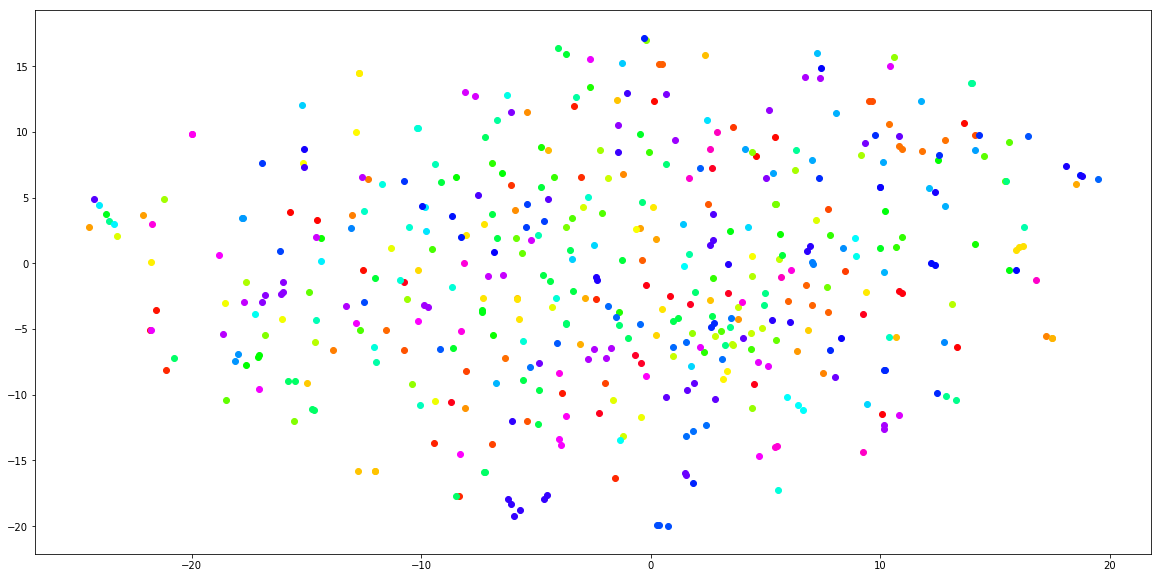

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import matplotlib
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

matplotlib.rcParams['figure.figsize'] = (20, 10)

tsne = TSNE(n_components=2)
twoDimVecs = tsne.fit_transform([doc['vec'] for doc in docs])

cm = plt.get_cmap('gist_rainbow')
cNorm = colors.Normalize(vmin=0, vmax=num_colors-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

fig, ax = plt.subplots()
for doc, twoDimVec in zip(docs, twoDimVecs):
    ax.scatter(twoDimVec[0], twoDimVec[1], color=scalarMap.to_rgba(doc['color']))
plt.show()